### Load and Prepare Data ###

In [37]:
import pandas as pd

In [38]:
#df = pd.read_csv("../data/kickstarter_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_one_hot_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_final_data.csv")

df = pd.read_csv("../../data/final.csv")

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#eliminate all non-numerical columns
df = df.select_dtypes(include=['number'])

#y is the target feature
y = df['SuccessfulBool']
#X consists of all features other than the target feature
X = df.drop('SuccessfulBool', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

### Utility Functions ###

In [40]:
def plot_cv_scores(cv_scores):
    plt.boxplot(cv_scores, vert=True)  # vert=True is default, but can be specified explicitly
    plt.title("Cross-Validation Accuracy Scores")
    plt.ylabel("Accuracy")
    plt.xticks([1], ["Best Grid Model"])
    plt.grid(True)
    plt.show()
    '''
    plt.figure(figsize=(8, 5))
    plt.boxplot(cv_scores, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    plt.title("10-Fold Cross-Validation Scores")
    plt.xlabel("Accuracy")
    plt.yticks([1], ["Model"])
    plt.grid(True, axis='x')
    plt.show()
    '''

### Decision Tree ###

In [41]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#thresholds = np.arange()

def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):
    clf = DecisionTreeClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    '''
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    '''
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Threshold: 0.10 -> F1 Score: 0.5725
Threshold: 0.20 -> F1 Score: 0.5947
Threshold: 0.30 -> F1 Score: 0.6004
Threshold: 0.40 -> F1 Score: 0.5858
Threshold: 0.50 -> F1 Score: 0.4764
Threshold: 0.60 -> F1 Score: 0.3778
{'cv_accuracy': np.float64(0.7531489806285885), 'best_params': {'max_depth': 11, 'min_samples_leaf': 13, 'min_samples_split': 2}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6003668229060526, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.63      0.74      4384\n           1       0.48      0.82      0.60      1806\n\n    accuracy                           0.68      6190\n   macro avg       0.68      0.72      0.67      6190\nweighted avg       0.77      0.68      0.70      6190\n', 'confusion_matrix': array([[2756, 1628],
       [ 333, 1473]])}, 'best_model': DecisionTreeClassifier(max_depth=11, min_samples_leaf=13, random

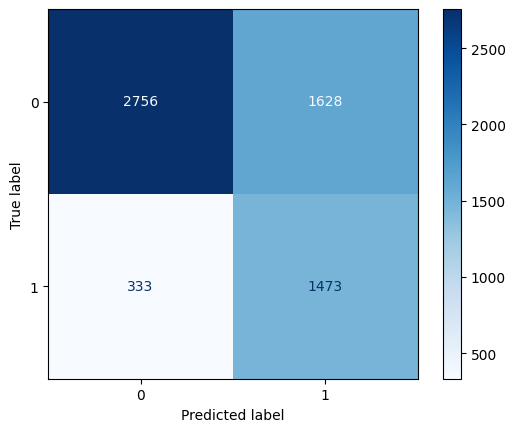

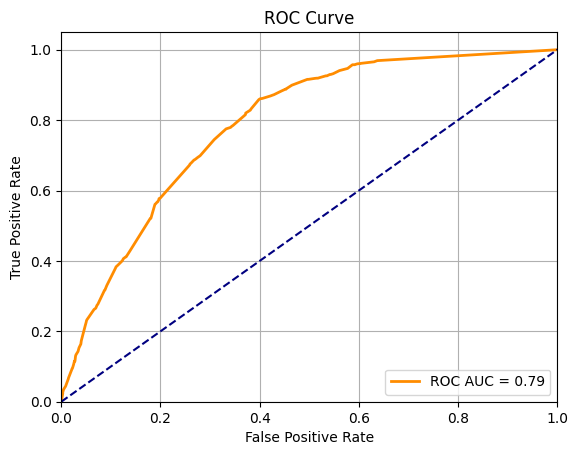

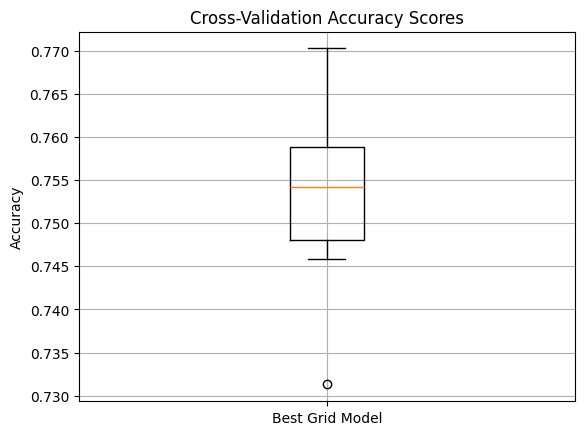

In [42]:

decision_tree_param_grid = {
    'max_depth': range(10, 12),
    'min_samples_leaf': range(12, 15),
    'min_samples_split': range(2, 10)
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_decision_tree = grid_search_roc_auc_tree(X, y, param_grid=decision_tree_param_grid, return_feature_importance=False, return_cv_scores=False)

print(result_decision_tree)


best_model_index = result_decision_tree['best_index']
print(f"mean cv_score: {result_decision_tree['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_decision_tree['grid'].cv_results_['std_test_score'][best_model_index]}")


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_decision_tree['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_decision_tree['fpr'], result_decision_tree['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_decision_tree['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_decision_tree['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)

In [43]:
print(result_decision_tree)

{'cv_accuracy': np.float64(0.7531489806285885), 'best_params': {'max_depth': 11, 'min_samples_leaf': 13, 'min_samples_split': 2}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6003668229060526, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.63      0.74      4384\n           1       0.48      0.82      0.60      1806\n\n    accuracy                           0.68      6190\n   macro avg       0.68      0.72      0.67      6190\nweighted avg       0.77      0.68      0.70      6190\n', 'confusion_matrix': array([[2756, 1628],
       [ 333, 1473]])}, 'best_model': DecisionTreeClassifier(max_depth=11, min_samples_leaf=13, random_state=42), 'roc_auc': np.float64(0.7862070546475253), 'fpr': array([0.        , 0.00296533, 0.00296533, 0.00364964, 0.00456204,
       0.00524635, 0.00707117, 0.00866788, 0.01414234, 0.01459854,
       0.02144161, 0.02166971, 0.02258212, 0.02486314, 0.02645985,
       0.0276003

### Decision Tree Results ###

{'cv_accuracy': np.float64(0.7512807081444277), 'best_params': {'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 10}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6046808510638297}}

- Cross validation (10 fold) accuracy: 0.751
- Parameters: max_depth 8, min_samples_leaf: 14, min_samples_split: 10, threshold 0.3
- F1 score: 0.604

#### Confusion Matrix: ####

<pre>              precision    recall  f1-score   support

           0       0.87      0.71      0.78      4384
           1       0.51      0.73      0.60      1806

    accuracy                           0.71      6190
   macro avg       0.69      0.72      0.69      6190
weighted avg       0.76      0.71      0.73      6190</pre>

## Gradient Boost Decision Trees ##

Rerun the above tests but with Gradient Boost Classifier. Gradients of the loss function.

In [44]:
from sklearn.ensemble import GradientBoostingClassifier


def grid_search_roc_auc_gradient_boost_tree(X, y, param_grid, cv=10, random_state=42):
    #    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    clf = GradientBoostingClassifier(random_state=random_state)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Threshold: 0.10 -> F1 Score: 0.5702
Threshold: 0.20 -> F1 Score: 0.6318
Threshold: 0.30 -> F1 Score: 0.6513
Threshold: 0.40 -> F1 Score: 0.6352
Threshold: 0.50 -> F1 Score: 0.5729
Threshold: 0.60 -> F1 Score: 0.4543
{'cv_accuracy': np.float64(0.7833401067775978), 'best_params': {'learning_rate': np.float64(0.07999999999999999), 'loss': 'log_loss', 'max_depth': 4, 'n_estimators': 100}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6512549537648613, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.91      0.71      0.80      4384\n           1       0.54      0.82      0.65      1806\n\n    accuracy                           0.74      6190\n   macro avg       0.72      0.77      0.72      6190\nweighted avg       0.80      0.74      0.76      6190\n', 'confusion_matrix': array([[3127, 1257],
       [ 327, 1479]])}, 'best_model': GradientBoostingClassifier(learning_rate=np.float64(0.07999999999999999),
           

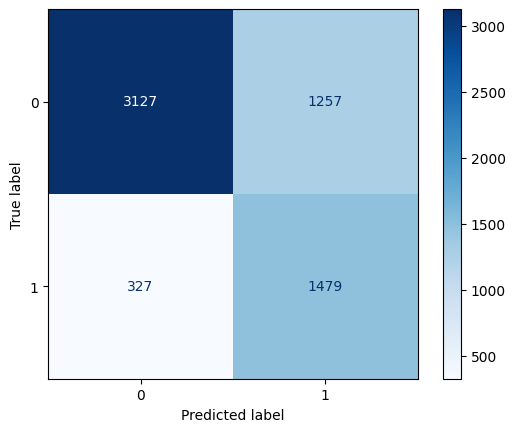

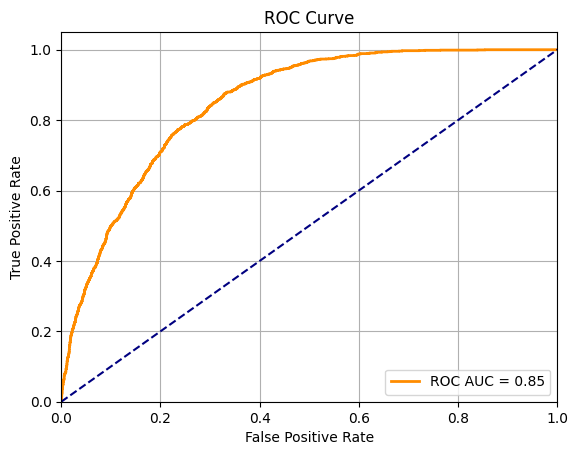

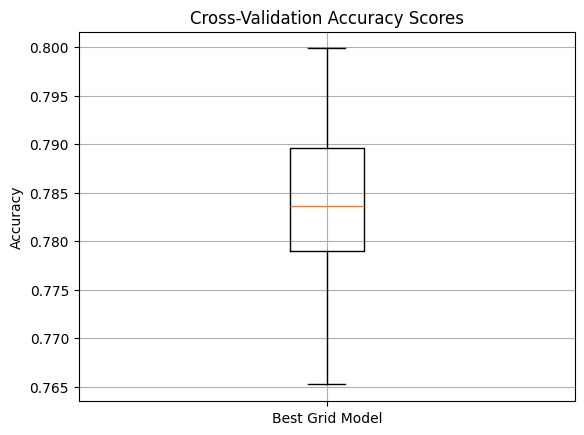

In [45]:

gradient_boost_tree_param_grid = {
    'loss': ['log_loss'],#loss function. log_loss is the default
    'learning_rate': np.arange(0.06, 0.09, 0.01),
    'n_estimators': range(75, 125, 25),
    'max_depth': [4],#smaller since there are many estimators.
    #'min_samples_leaf': range(10, 30, 5),
    #'min_samples_split': range(10, 15),
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_gradient_boost = grid_search_roc_auc_gradient_boost_tree(X, y, param_grid=gradient_boost_tree_param_grid)

print(result_gradient_boost)

best_model_index = result_gradient_boost['best_index']
print(f"mean cv_score: {result_gradient_boost['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_gradient_boost['grid'].cv_results_['std_test_score'][best_model_index]}")



#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_gradient_boost['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_gradient_boost['fpr'], result_gradient_boost['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_gradient_boost['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_gradient_boost['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)


### Adaboost ###

In [46]:
from sklearn.ensemble import AdaBoostClassifier


def grid_search_roc_auc_adaboost_tree(X, y, param_grid, cv=10, random_state=42):

    #basic learner decision tree
    dt = DecisionTreeClassifier(random_state=random_state)

    ada_boost = AdaBoostClassifier(estimator=dt, random_state=random_state)

    grid = GridSearchCV(ada_boost, param_grid, cv=10, n_jobs=-1, verbose=1)

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_


    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Fitting 10 folds for each of 33 candidates, totalling 330 fits
Threshold: 0.10 -> F1 Score: 0.4517
Threshold: 0.20 -> F1 Score: 0.5357
Threshold: 0.30 -> F1 Score: 0.5877
Threshold: 0.40 -> F1 Score: 0.6426
Threshold: 0.50 -> F1 Score: 0.5769
Threshold: 0.60 -> F1 Score: 0.2299
{'cv_accuracy': np.float64(0.7825088901455971), 'best_params': {'estimator__max_depth': 9, 'learning_rate': np.float64(0.07), 'n_estimators': 400}, 'best_thresh': {'thresh': np.float64(0.4), 'f1': 0.6425933524825606, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.92      0.66      0.77      4384\n           1       0.51      0.87      0.64      1806\n\n    accuracy                           0.72      6190\n   macro avg       0.72      0.76      0.71      6190\nweighted avg       0.80      0.72      0.73      6190\n', 'confusion_matrix': array([[2882, 1502],
       [ 240, 1566]])}, 'best_model': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=

/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

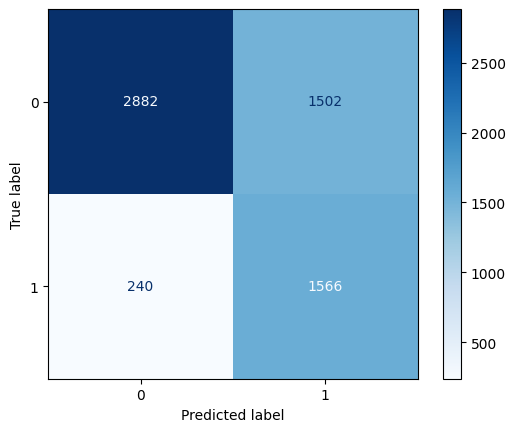

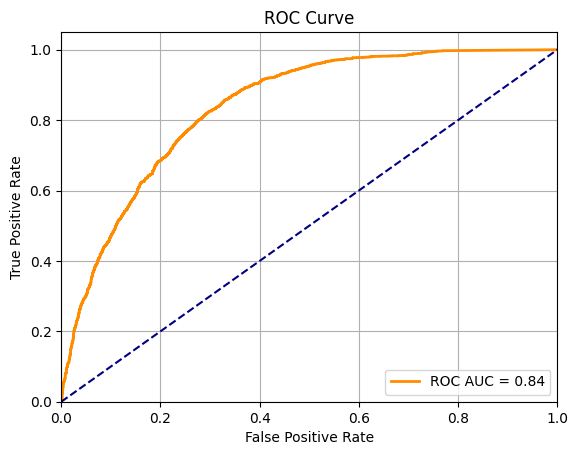

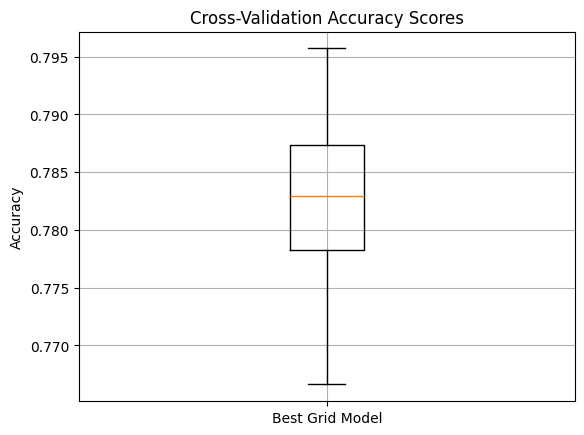

In [47]:
ada_boost_param_grid = {
    'estimator__max_depth': [9],#range(7, 12),  # Tuning the depth of the DecisionTree
    'n_estimators': [400],  # Number of estimators in AdaBoost
    'learning_rate': np.arange(0.05, 0.7, 0.02),  # Learning rate of AdaBoost
    #'estimator__min_samples_leaf': range(6, 7, 1)
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_ada_boost = grid_search_roc_auc_adaboost_tree(X, y, param_grid=ada_boost_param_grid)

print(result_ada_boost)

best_model_index = result_ada_boost['best_index']
print(f"mean cv_score: {result_ada_boost['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_ada_boost['grid'].cv_results_['std_test_score'][best_model_index]}")




#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_ada_boost['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_ada_boost['fpr'], result_ada_boost['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_ada_boost['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_ada_boost['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)

## Random Forest ##

In [49]:
from sklearn.ensemble import RandomForestClassifier


def grid_search_roc_auc_random_forest_tree(X, y, param_grid, cv=10, random_state=42):
    #    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    clf = RandomForestClassifier(random_state=random_state)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Threshold: 0.10 -> F1 Score: 0.5284
Threshold: 0.20 -> F1 Score: 0.6029
Threshold: 0.30 -> F1 Score: 0.6403
Threshold: 0.40 -> F1 Score: 0.6164
Threshold: 0.50 -> F1 Score: 0.5054
Threshold: 0.60 -> F1 Score: 0.3472
{'cv_accuracy': np.float64(0.7751698952352654), 'best_params': {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.640326390380073, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.91      0.69      0.78      4384\n           1       0.52      0.83      0.64      1806\n\n    accuracy                           0.73      6190\n   macro avg       0.71      0.76      0.71      6190\nweighted avg       0.79      0.73      0.74      6190\n', 'confusion_matrix': array([[3024, 1360],
       [ 315, 1491]])}, 'best_model': RandomForestClassifier(ma

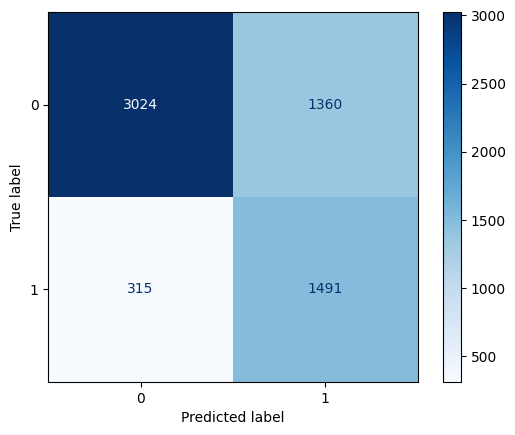

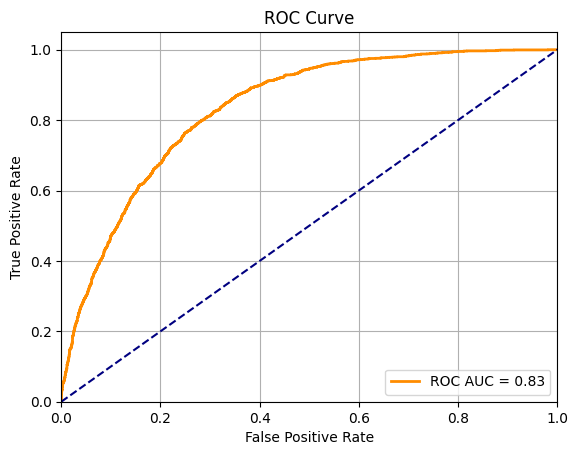

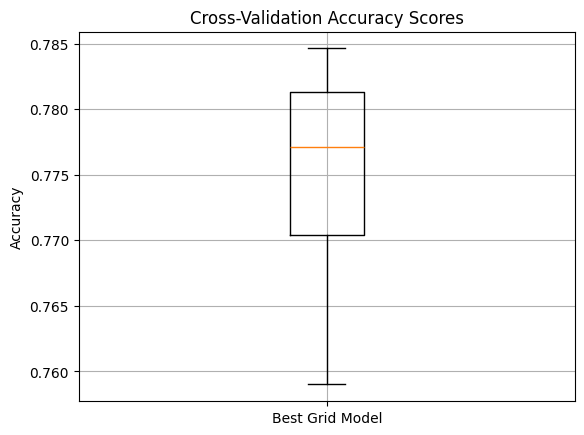

In [51]:

random_forest_tree_param_grid = {
    'criterion': ['gini'],#split criterion. gini is default
    #'learning_rate': np.arange(0.01, 0.2, 0.02),
    'n_estimators': range(40, 60, 5),
    'min_samples_split': range(5, 10, 1),
    'max_depth': range(18, 23, 1),#smaller since there are many estimators.
    'min_samples_leaf': range(2, 7, 5),
    'min_samples_split': range(4, 8),
}

'''
ada_boost_param_grid = {
    'estimator__max_depth': range(4, 10),  # Tuning the depth of the DecisionTree
    'n_estimators': [200, 400, 600],  # Number of estimators in AdaBoost
    'learning_rate': np.arange(0.2, 1.0, 0.2),  # Learning rate of AdaBoost
}
'''

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_random_forest = grid_search_roc_auc_random_forest_tree(X, y, param_grid=random_forest_tree_param_grid)

print(result_random_forest)
best_model_index = result_random_forest['best_index']
print(f"mean cv_score: {result_random_forest['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_random_forest['grid'].cv_results_['std_test_score'][best_model_index]}")


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_random_forest['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_random_forest['fpr'], result_random_forest['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_random_forest['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_random_forest['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)
